## Wine Quality

https://www.kaggle.com/datasets/rajyellow46/wine-quality

**Цель:** Предсказание оценки качества вина 

### Importing libraries

In [1]:
import os
import shutil
import pandas as pd
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import datetime

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Usefull functions

In [3]:
statistic = [['model', 'RMSE_Test', 'RMSE_Train', 'R2_Test', 'R2_Train']]

scores=['accuracy', 'f1']

classifiers = {
    "Nearest Neighbors": KNeighborsClassifier(),
    "RBF SVM": SVC(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Neural Net": MLPClassifier(max_iter=1000, random_state=42),
    "QDA": QuadraticDiscriminantAnalysis()
}

params = {
    "Nearest Neighbors": {'n_neighbors': range(3, 10, 1)}, 
    "RBF SVM": {'C': [0.002, 0.1, 1, 5], 'kernel': ['rbf'], 'gamma': [x / 2.0 for x in range(2, 6, 2)]},
    "Decision Tree": {'max_depth': range(3, 50, 2), 'min_samples_split': range(2, 10, 1)},
    "Random Forest": {'max_depth': range(3, 50, 5), 'min_samples_split': range(2, 10, 2), 'n_estimators': range(10, 60, 5)},
    "Neural Net": {'solver' : ['lbfgs', 'sgd', 'adam'], 'alpha': [x / 10_000.0 for x in (1, 10_000, 1000)]},
    "QDA": {'reg_param': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]}
}

best_params = {
    "Nearest Neighbors": {},
    "RBF SVM": {},
    "Decision Tree": {},
    "Random Forest": {},
    "Neural Net": {},
    "QDA": {}
}

def get_grid_search_cv(model_name, model):
    grid_search_cv_model = GridSearchCV( #подбор гиперпараметров
        model,
        param_grid=params.get(model_name),
        cv=4, #crossvalidation
        scoring=scores,
        refit=scores[0],
        n_jobs=-1,
        verbose=1
    )
    
    return grid_search_cv_model


def train(df, model_name, use_best_params=False):
    X_train, X_test, Y_train, Y_test = train_test_split(df[df.columns[:-1]],
                                                    df[df.columns[-1]], test_size=0.2, random_state=2)
    models_log = []
    for key, value in classifiers.items():
        start_time = datetime.datetime.now()
        if use_best_params:
            model = value(**best_params[key])
        else:
            model = get_grid_search_cv(key, value)
            
        model.fit(X_train, Y_train)  
        end_time = datetime.datetime.now()
        
        F1_Test = f1_score(Y_test, model.predict(X_test), average='micro')
        F1_Train = f1_score(Y_train, model.predict(X_train), average='micro')
        R2_Test = r2_score(Y_test, model.predict(X_test))
        R2_Train = r2_score(Y_train, model.predict(X_train))

        print("{}: {}".format(key, model.best_params_))
        print("{} Test R2:".format(key), R2_Test)
        print("{} Train R2:".format(key), R2_Train)
        print("{} Test F1:".format(key), F1_Test)
        print("{} Train F1:".format(key), F1_Train)
        print("Runtime seconds:", (end_time - start_time).seconds)
        print()
        
        best_params[key] = model.best_params_
        
        models_log.append([F1_Test, F1_Train, R2_Test, R2_Train])
        
    statistic.append([model_name, models_log])

def load_data_from_kaggle():
    data_path = 'wine-quality-data'

    if not os.path.exists(data_path):
        with zipfile.ZipFile('wine-quality.zip', 'r') as zipp:
            zipp.extractall(data_path)

    train_path = "\\".join([data_path, os.listdir(data_path)[0]])
    
    return pd.read_csv(train_path)

### Getting data

In [4]:
!kaggle datasets download -d rajyellow46/wine-quality

wine-quality.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
df = load_data_from_kaggle()
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### Preprocessing

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


**Описание переменных**

* type - тип вина (красное/белое)                    
* fixed acidity - фиксированная кислотность           
* volatile acidity - изменчивая кислотность       
* citric acid - лимонная кислота            
* residual sugar - остаточный сахар         
* chlorides - хлориды               
* free sulfur dioxide - свободный диоксид серы    
* total sulfur dioxide - общий диоксид серы   
* density - плотность                
* pH - рН                     
* sulphates - сульфаты              
* alcohol - алкоголь                
* quality - оценка качества                

Посмотрев на описание датафрейма можем понять что в наших данных есть пропуски, их нужно заполнить.

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


**Столбцы с пропусками:**

In [8]:
df.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

**fixed acidity**

Посмотрим на пропуски в столбце "fixed acidity", видим что пропуски содержатся по двум типам вина - красное и белое. Заменим пустые значения в столбце "fixed acidity" на среднее значение по типам вина.

In [9]:
df[df['fixed acidity'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
17,white,NaN,0.660,0.48,1.2,0.029,29.0,75.0,0.98920,3.33,0.39,12.8,8
174,white,NaN,0.270,0.31,17.7,0.051,33.0,173.0,0.99900,3.09,0.64,10.2,5
249,white,NaN,0.410,0.14,10.4,0.037,18.0,119.0,0.99600,3.38,0.45,10.0,5
267,white,NaN,0.580,0.07,6.9,0.043,34.0,149.0,0.99440,3.34,0.57,9.7,5
368,white,NaN,0.290,0.48,2.3,0.049,36.0,178.0,0.99310,3.17,0.64,10.6,6
518,white,NaN,0.130,0.28,1.9,0.050,20.0,78.0,0.99180,3.43,0.64,10.8,6
1079,white,NaN,NaN,0.29,6.2,0.046,29.0,227.0,0.99520,3.29,0.53,10.1,6
2902,white,NaN,0.360,0.14,8.9,0.036,38.0,155.0,0.99622,3.27,NaN,9.4,5
6428,red,NaN,0.440,0.09,2.2,0.063,9.0,18.0,0.99444,NaN,0.69,11.3,6
6429,red,NaN,0.705,0.10,2.8,0.081,13.0,28.0,0.99631,NaN,0.66,10.2,5


In [10]:
print("white mean: {}".format(df[df['type'] == 'white']['fixed acidity'].mean()))
print("red mean: {}".format(df[df['type'] == 'red']['fixed acidity'].mean()))

white mean: 6.855531697341513
red mean: 8.32210394489668


In [11]:
df.loc[(df['fixed acidity'].isna()) & (df['type'] == 'white'), 'fixed acidity'] = df[df['type'] == 'white']['fixed acidity'].mean()
df.loc[(df['fixed acidity'].isna()) & (df['type'] == 'red'), 'fixed acidity'] = df[df['type'] == 'red']['fixed acidity'].mean()

In [12]:
df[df['fixed acidity'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


**volatile acidity**

Посмотрим на пропуски в столбце "volatile acidity", видим что пропуски содержатся по двум типам вина - красное и белое, а также можно заметить что значения в столбце "free sulfur dioxide" варьируется от 8 до 55. Можно разделить эти строки на 3 диапазона: от 5 до 15, от 20 до 40, и от 45 до 60, и посчитать по ним среднее.

In [13]:
df[df['volatile acidity'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
86,white,7.200000,NaN,0.63,11.0,0.044,55.0,156.0,0.99740,3.09,0.44,8.7,6
521,white,7.900000,NaN,0.26,2.1,0.039,8.0,143.0,0.99420,3.05,0.74,9.8,5
621,white,6.500000,NaN,0.43,8.9,0.083,50.0,171.0,0.99650,2.85,0.50,9.0,5
812,white,6.400000,NaN,0.28,1.1,0.055,9.0,160.0,0.99405,3.42,0.50,9.1,7
1079,white,6.855532,NaN,0.29,6.2,0.046,29.0,227.0,0.99520,3.29,0.53,10.1,6
2894,white,6.400000,NaN,0.36,1.4,0.044,22.0,68.0,0.99014,3.15,0.50,11.7,7
4895,white,6.500000,NaN,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
6486,red,7.200000,NaN,0.33,2.5,0.068,34.0,102.0,0.99414,3.27,0.78,12.8,6


In [14]:
print("white, sulfur  between 5-15 mean: {}".format(df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 5) & (df['free sulfur dioxide'] < 15), 'volatile acidity'].mean()))
print("white, sulfur  between 20-40 mean: {}".format(df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 20) & (df['free sulfur dioxide'] < 40), 'volatile acidity'].mean()))
print("white, sulfur  between 45-60 mean: {}".format(df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 45) & (df['free sulfur dioxide'] < 60), 'volatile acidity'].mean()))
print("red, sulfur  between 20-40 mean: {}".format(df.loc[(df['type'] == 'red') & (df['free sulfur dioxide'] > 20) & (df['free sulfur dioxide'] < 40), 'volatile acidity'].mean()))

white, sulfur  between 5-15 mean: 0.30465736040609137
white, sulfur  between 20-40 mean: 0.27927849264705884
white, sulfur  between 45-60 mean: 0.26686331775700933
red, sulfur  between 20-40 mean: 0.5209079283887468


In [15]:
df.loc[(df['volatile acidity'].isna()) & (df['type'] == 'white') & (df['free sulfur dioxide'] > 5) & (df['free sulfur dioxide'] < 15), 'volatile acidity'] = df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 5) & (df['free sulfur dioxide'] < 15), 'volatile acidity'].mean()
df.loc[(df['volatile acidity'].isna()) & (df['type'] == 'white') & (df['free sulfur dioxide'] > 20) & (df['free sulfur dioxide'] < 40), 'volatile acidity'] = df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 20) & (df['free sulfur dioxide'] < 40), 'volatile acidity'].mean()
df.loc[(df['volatile acidity'].isna()) & (df['type'] == 'white') & (df['free sulfur dioxide'] > 45) & (df['free sulfur dioxide'] < 60), 'volatile acidity'] = df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 45) & (df['free sulfur dioxide'] < 60), 'volatile acidity'].mean()
df.loc[(df['volatile acidity'].isna()) & (df['type'] == 'red') & (df['free sulfur dioxide'] > 20) & (df['free sulfur dioxide'] < 40), 'volatile acidity'] = df.loc[(df['type'] == 'red') & (df['free sulfur dioxide'] > 20) & (df['free sulfur dioxide'] < 40), 'volatile acidity'].mean() 

In [16]:
df[df['volatile acidity'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


**citric acid**

Посмотрим на пропуски в столбце "citric acid", видим что пропуски содержатся по двум типам вина - красное и белое, а также можно заметить что значения в столбце "residual sugar" варьируется от 2 до 13. Можно разделить эти строки на 3 диапазона: меньше 5, от 5 до 10, от 10 до 15, и посчитать по ним среднее.

In [17]:
df[df['citric acid'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
268,white,5.3,0.585,NaN,7.1,0.044,34.0,145.0,0.9945,3.34,0.57,9.7,6
909,white,7.5,0.240,NaN,13.0,0.049,46.0,217.0,0.9985,3.08,0.53,8.8,5
6320,red,7.0,0.540,NaN,2.1,0.079,39.0,55.0,0.9956,3.39,0.84,11.4,6


In [18]:
print("white, sugar between 20-40 mean: {}".format(df.loc[(df['type'] == 'white') & (df['residual sugar'] > 5) & (df['free sulfur dioxide'] <= 10), 'citric acid'].mean()))
print("white, sugar between 45-60 mean: {}".format(df.loc[(df['type'] == 'white') & (df['residual sugar'] > 10) & (df['free sulfur dioxide'] < 15), 'citric acid'].mean()))
print("red, sugar between 20-40 mean: {}".format(df.loc[(df['type'] == 'red') & (df['free sulfur dioxide'] <= 5), 'citric acid'].mean()))

white, sugar between 20-40 mean: 0.3408928571428572
white, sugar between 45-60 mean: 0.36749999999999994
red, sugar between 20-40 mean: 0.3003030303030303


In [19]:
df.loc[(df['citric acid'].isna()) & (df['type'] == 'white') & (df['residual sugar'] > 5) & (df['residual sugar'] <= 10), 'citric acid'] = df.loc[(df['type'] == 'white') & (df['residual sugar'] > 5) & (df['free sulfur dioxide'] <= 10), 'citric acid'].mean()
df.loc[(df['citric acid'].isna()) & (df['type'] == 'white') & (df['residual sugar'] > 10) & (df['residual sugar'] < 15), 'citric acid'] = df.loc[(df['type'] == 'white') & (df['residual sugar'] > 10) & (df['free sulfur dioxide'] < 15), 'citric acid'].mean()
df.loc[(df['citric acid'].isna()) & (df['type'] == 'red') & (df['residual sugar'] <= 5), 'citric acid'] = df.loc[(df['type'] == 'red') & (df['free sulfur dioxide'] <= 5), 'citric acid'].mean()

In [20]:
df[df['citric acid'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


**residual sugar**

Посмотрим на пропуски в столбце "residual sugar", видим что пропуски содержатся по типу вина - белое. Заменим пустые значения в столбце "residual sugar" на среднее значение по типу вина - white.

In [21]:
df[df['residual sugar'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
33,white,6.2,0.120,0.34,NaN,0.045,43.0,117.0,0.9939,3.42,0.51,9.0,6
438,white,7.4,0.155,0.34,NaN,0.045,73.5,214.0,0.9934,3.18,0.61,9.9,7


In [22]:
print("white: {}".format(df.loc[df['type'] == 'white', 'residual sugar'].mean()))

white: 6.3932495915032685


In [23]:
df.loc[(df['residual sugar'].isna()) & (df['type'] == 'white'), 'residual sugar'] = df.loc[df['type'] == 'white', 'residual sugar'].mean()

In [24]:
df[df['residual sugar'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


**chlorides**

Посмотрим на пропуски в столбце "chlorides", видим что пропуски содержатся по типу вина - белое, а также можно заметить что значения в столбце "free sulfur dioxide" - 4, 56. Можно посчитать среднее по столбцу "free sulfur dioxide" для этих строк в 2 диапазонах: меньше 10 и от 50 до 60.	

In [25]:
df[df['chlorides'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
98,white,9.8,0.36,0.46,10.5,NaN,4.0,83.0,0.9956,2.89,0.30,10.1,4
747,white,7.2,0.29,0.40,7.6,NaN,56.0,177.0,0.9928,3.04,0.32,11.5,6


In [26]:
print("white, free sulfur dioxide < 10: {}".format(df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] < 10), 'chlorides'].mean()))
print("white, free sulfur dioxide between 50-60: {}".format(df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 50) & (df['free sulfur dioxide'] < 60), 'chlorides'].mean()))

white, free sulfur dioxide < 10: 0.042976047904191614
white, free sulfur dioxide between 50-60: 0.047722567287784685


In [27]:
df.loc[(df['chlorides'].isna()) & (df['type'] == 'white') & (df['free sulfur dioxide'] < 10), 'chlorides'] = df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] < 10), 'chlorides'].mean()
df.loc[(df['chlorides'].isna()) & (df['type'] == 'white') & (df['free sulfur dioxide'] > 50) & (df['free sulfur dioxide'] < 60), 'chlorides'] = df.loc[(df['type'] == 'white') & (df['free sulfur dioxide'] > 50) & (df['free sulfur dioxide'] < 60), 'chlorides'].mean()

In [28]:
df[df['chlorides'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


**pH**

Посмотрим на пропуски в столбце "pH", видим что пропуски содержатся по двум типам вина - красное и белое, а также можно заметить что значения в столбце "residual sugar" варьируется от 0.9 до 17.5. Можно разделить эти строки на 2 диапазона: меньше 5, от 10 до 20, и посчитать по ним среднее.

In [29]:
df[df['pH'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
54,white,6.800000,0.200,0.59,0.9,0.147,38.0,132.0,0.99300,NaN,0.38,9.1,6
139,white,8.100000,0.280,0.39,1.9,0.029,18.0,79.0,0.99230,NaN,0.52,11.8,6
440,white,6.700000,0.220,0.37,1.6,0.028,24.0,102.0,0.99130,NaN,0.59,11.6,7
587,white,6.100000,0.320,0.25,1.7,0.034,37.0,136.0,0.99200,NaN,0.50,10.8,7
697,white,7.500000,0.310,0.51,14.8,0.039,62.0,204.0,0.99820,NaN,0.60,9.5,5
972,white,6.800000,0.220,0.35,17.5,0.039,38.0,153.0,0.99940,NaN,0.42,9.0,6
4892,white,6.500000,0.230,0.38,1.3,0.032,29.0,112.0,0.99298,NaN,0.54,9.7,5
6428,red,8.322104,0.440,0.09,2.2,0.063,9.0,18.0,0.99444,NaN,0.69,11.3,6
6429,red,8.322104,0.705,0.10,2.8,0.081,13.0,28.0,0.99631,NaN,0.66,10.2,5


In [30]:
print("white, sugar < 5: {}".format(df.loc[(df['type'] == 'white') & (df['residual sugar'] < 5), 'pH'].mean()))
print("white, sugar between 10-20: {}".format(df.loc[(df['type'] == 'white') & (df['residual sugar'] > 10) & (df['residual sugar'] < 20), 'pH'].mean()))
print("red, sugar < 5: {}".format(df.loc[(df['type'] == 'red') & (df['residual sugar'] < 5), 'pH'].mean()))

white, sugar < 5: 3.213
white, sugar between 10-20: 3.137612958226769
red, sugar < 5: 3.312169312169312


In [31]:
df.loc[(df['pH'].isna()) & (df['type'] == 'white') & (df['residual sugar'] < 5), 'pH'] = df.loc[(df['type'] == 'white') & (df['residual sugar'] < 5), 'pH'].mean()
df.loc[(df['pH'].isna()) & (df['type'] == 'white') & (df['residual sugar'] > 10) & (df['residual sugar'] < 20), 'pH'] = df.loc[(df['type'] == 'white') & (df['residual sugar'] > 10) & (df['residual sugar'] < 20), 'pH'].mean()
df.loc[(df['pH'].isna()) & (df['type'] == 'red') & (df['residual sugar'] < 5), 'pH'] = df.loc[(df['type'] == 'red') & (df['residual sugar'] < 5), 'pH'].mean()

In [32]:
df[df['pH'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


**sulphates**

Посмотрим на пропуски в столбце "sulphates", видим что пропуски содержатся по двум типам вина - красное и белое. Заменим пустые значения в столбце "sulphates" на среднее значение по типам вина.

In [33]:
df[df['sulphates'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
224,white,6.300000,0.495,0.22,1.8,0.046,31.0,140.0,0.99290,3.39,NaN,10.4,6
2902,white,6.855532,0.360,0.14,8.9,0.036,38.0,155.0,0.99622,3.27,NaN,9.4,5
6321,red,6.400000,0.530,0.09,3.9,0.123,14.0,31.0,0.99680,3.50,NaN,11.0,4
6493,red,5.900000,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6


In [34]:
print("white: {}".format(df.loc[df['type'] == 'white', 'sulphates'].mean()))
print("red: {}".format(df.loc[df['type'] == 'red', 'sulphates'].mean()))

white: 0.48983455882352944
red: 0.6580776455854727


In [35]:
df.loc[(df['sulphates'].isna()) & (df['type'] == 'white'), 'sulphates'] = df.loc[df['type'] == 'white', 'sulphates'].mean()
df.loc[(df['sulphates'].isna()) & (df['type'] == 'red'), 'sulphates'] = df.loc[df['type'] == 'red', 'sulphates'].mean()

In [36]:
df[df['sulphates'].isna()]

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


Данные после обработки

In [37]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.216475,0.339658,0.318730,5.444619,0.056038,30.525319,115.744574,0.994697,3.218395,0.531241,10.491801,5.818378
std,1.295958,0.164574,0.145233,4.757421,0.035031,17.749400,56.521855,0.002999,0.160652,0.148787,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Feature selection

Значения в столбце "type" имеют строковое значение, что не удобно для дальнейшей работы. Преобразуем значения из этого столбца в булевые.

In [38]:
df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)
df_encoded

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_white
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,6,True
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,6,True
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,6,True
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6,True
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,5,False
6493,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.658078,11.2,6,False
6494,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,6,False
6495,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,5,False


In [39]:
type_white = df_encoded.pop("type_white")
df_encoded.insert(0, 'type_white', type_white)
df_encoded.head()

,type_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,True,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,True,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,True,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,True,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,True,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Запустим несколько моделей на основе наших очищенных данных и посмотрим на полученные метрики.

In [40]:
train(df_encoded, model_name='После удаления пропусков')

Fitting 4 folds for each of 7 candidates, totalling 28 fits
Nearest Neighbors: {'n_neighbors': 9}
Nearest Neighbors Test R2: -0.19863282661213066
Nearest Neighbors Train R2: 0.056651817613746935
Nearest Neighbors Test F1: 0.4707692307692308
Nearest Neighbors Train F1: 0.5828362516836636
Runtime seconds: 2

Fitting 4 folds for each of 8 candidates, totalling 32 fits
RBF SVM: {'C': 5, 'gamma': 1.0, 'kernel': 'rbf'}
RBF SVM Test R2: 0.23426352644029136
RBF SVM Train R2: 0.9994967467685323
RBF SVM Test F1: 0.6107692307692307
RBF SVM Train F1: 0.9996151625938041
Runtime seconds: 16

Fitting 4 folds for each of 192 candidates, totalling 768 fits
Decision Tree: {'max_depth': 19, 'min_samples_split': 2}
Decision Tree Test R2: 0.013731422055095255
Decision Tree Train R2: 0.9672885399545977
Decision Tree Test F1: 0.5892307692307692
Decision Tree Train F1: 0.9899942274389071
Runtime seconds: 4

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
Random Forest: {'max_depth': 23, 'min_s

Метрики качества моделей выше нам не особо нравятся. Мы хотим качество получше. Для этого посмотрим на матрицу корреляции и отберем только коррелирующие переменные с целевой переменной и не коррелирующие между собой.

In [41]:
df_encoded.corr()

,type_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
type_white,1.000000,-0.487491,-0.653009,0.187148,0.349015,-0.512642,0.471644,0.700357,-0.390645,-0.328901,-0.487110,0.032970,0.119323
fixed acidity,-0.487491,1.000000,0.220257,0.322975,-0.112491,0.298367,-0.283463,-0.329960,0.458965,-0.251598,0.300179,-0.095475,-0.077024
volatile acidity,-0.653009,0.220257,1.000000,-0.377831,-0.196712,0.377165,-0.353018,-0.414895,0.271059,0.260893,0.225863,-0.037623,-0.265824
citric acid,0.187148,0.322975,-0.377831,1.000000,0.142562,0.039201,0.133465,0.195272,0.096365,-0.328777,0.057199,-0.010534,0.085651
residual sugar,0.349015,-0.112491,-0.196712,0.142562,1.000000,-0.128981,0.403335,0.495755,0.552462,-0.267098,-0.185811,-0.359707,-0.036771
chlorides,-0.512642,0.298367,0.377165,0.039201,-0.128981,1.000000,-0.194941,-0.279550,0.362581,0.045066,0.395469,-0.256853,-0.200703
free sulfur dioxide,0.471644,-0.283463,-0.353018,0.133465,0.403335,-0.194941,1.000000,0.720934,0.025717,-0.145468,-0.188526,-0.179838,0.055463
total sulfur dioxide,0.700357,-0.329960,-0.414895,0.195272,0.495755,-0.279550,0.720934,1.000000,0.032395,-0.237966,-0.275653,-0.265740,-0.041385
density,-0.390645,0.458965,0.271059,0.096365,0.552462,0.362581,0.025717,0.032395,1.000000,0.011761,0.259514,-0.686745,-0.305858
pH,-0.328901,-0.251598,0.260893,-0.328777,-0.267098,0.045066,-0.145468,-0.237966,0.011761,1.000000,0.191651,0.121126,0.019334


<Axes: >

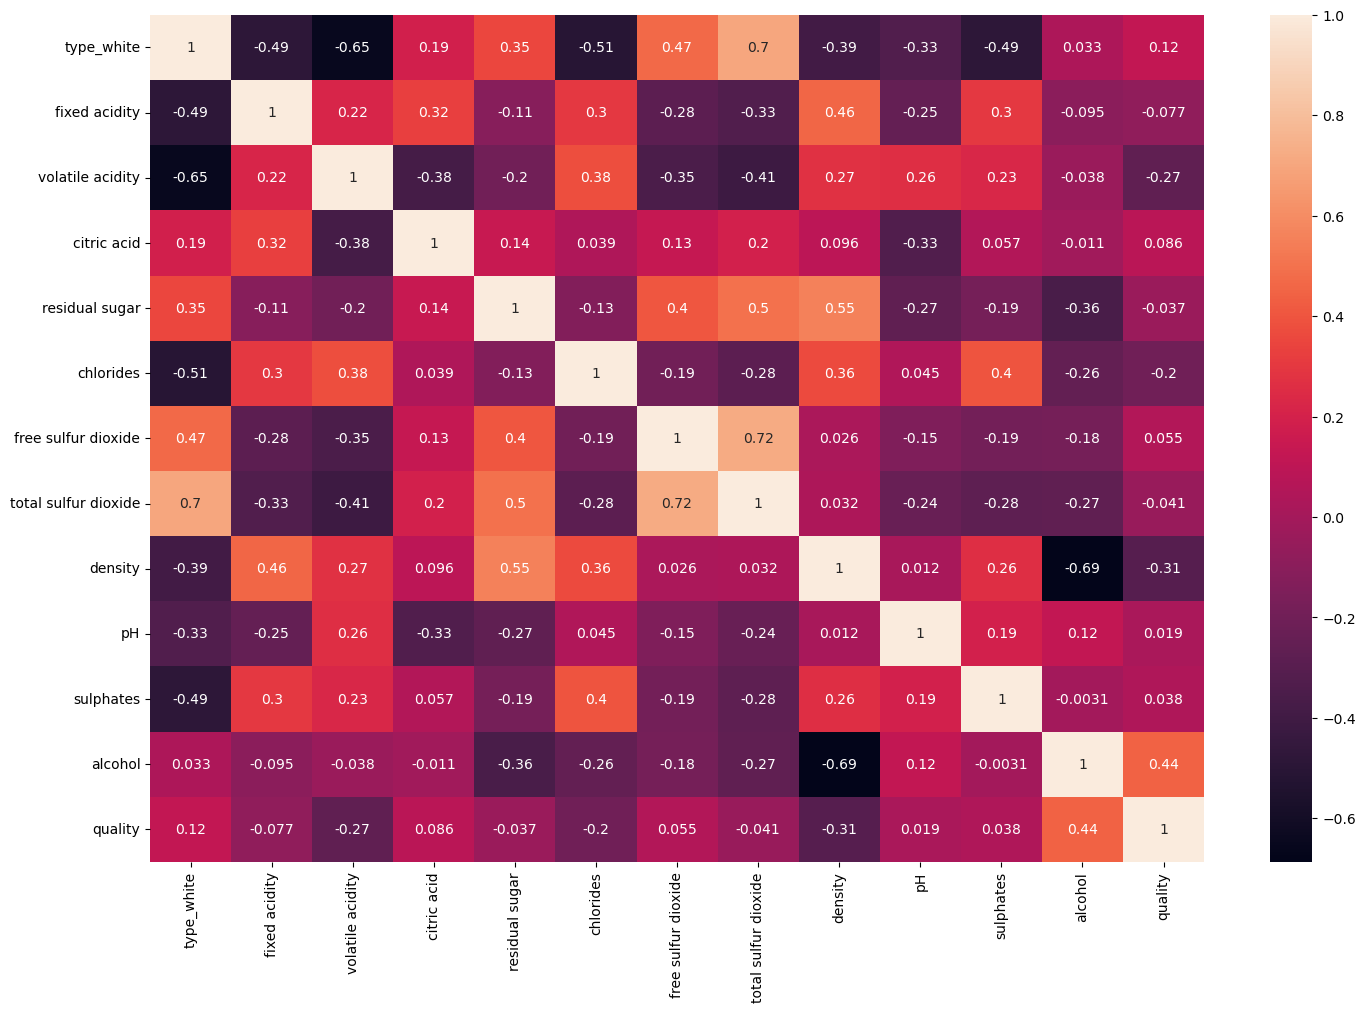

In [42]:
plt.subplots(figsize=(17,11))  
sns.heatmap(df_encoded.corr(), annot=True, fmt='.2g')

Отбросим следующие перменные

- fixed acidity
- residual sugar
- free sulfur dioxide
- total sulfur dioxide	
- pH
- sulphates

In [47]:
corr_less_df = df_encoded[df_encoded.columns.drop(['fixed acidity', 'residual sugar', 'total sulfur dioxide'])]
corr_less_df

,type_white,volatile acidity,citric acid,chlorides,free sulfur dioxide,density,pH,sulphates,alcohol,quality
0,True,0.270,0.36,0.045,45.0,1.00100,3.00,0.450000,8.8,6
1,True,0.300,0.34,0.049,14.0,0.99400,3.30,0.490000,9.5,6
2,True,0.280,0.40,0.050,30.0,0.99510,3.26,0.440000,10.1,6
3,True,0.230,0.32,0.058,47.0,0.99560,3.19,0.400000,9.9,6
4,True,0.230,0.32,0.058,47.0,0.99560,3.19,0.400000,9.9,6
...,...,...,...,...,...,...,...,...,...,...
6492,False,0.600,0.08,0.090,32.0,0.99490,3.45,0.580000,10.5,5
6493,False,0.550,0.10,0.062,39.0,0.99512,3.52,0.658078,11.2,6
6494,False,0.510,0.13,0.076,29.0,0.99574,3.42,0.750000,11.0,6
6495,False,0.645,0.12,0.075,32.0,0.99547,3.57,0.710000,10.2,5


Обучим наши модели на новом датасете из полезных признаков

In [48]:
train(corr_less_df, model_name='После исключения коррелирующих между собой признаков')

Fitting 4 folds for each of 7 candidates, totalling 28 fits
Nearest Neighbors: {'n_neighbors': 7}
Nearest Neighbors Test R2: -0.030170802428994836
Nearest Neighbors Train R2: 0.20485989428099238
Nearest Neighbors Test F1: 0.5238461538461539
Nearest Neighbors Train F1: 0.6320954396767365
Runtime seconds: 0

Fitting 4 folds for each of 8 candidates, totalling 32 fits
RBF SVM: {'C': 5, 'gamma': 2.0, 'kernel': 'rbf'}
RBF SVM Test R2: 0.13420729389515607
RBF SVM Train R2: 0.6386641798061725
RBF SVM Test F1: 0.5761538461538461
RBF SVM Train F1: 0.8206657687127188
Runtime seconds: 10

Fitting 4 folds for each of 192 candidates, totalling 768 fits
Decision Tree: {'max_depth': 19, 'min_samples_split': 2}
Decision Tree Test R2: 0.12501845621243957
Decision Tree Train R2: 0.9821345102828957
Decision Tree Test F1: 0.6192307692307693
Decision Tree Train F1: 0.9913411583605927
Runtime seconds: 3

Fitting 4 folds for each of 400 candidates, totalling 1600 fits
Random Forest: {'max_depth': 23, 'min_sa

Лучшие параметры для моделей

In [49]:
best_params

{'Nearest Neighbors': {'n_neighbors': 7},
 'RBF SVM': {'C': 5, 'gamma': 2.0, 'kernel': 'rbf'},
 'Decision Tree': {'max_depth': 19, 'min_samples_split': 2},
 'Random Forest': {'max_depth': 23,
  'min_samples_split': 2,
  'n_estimators': 40},
 'Neural Net': {'alpha': 0.1, 'solver': 'lbfgs'},
 'QDA': {'reg_param': 0.1}}

### Deployment

Сохраним подготовленный датасет

In [46]:
corr_less_df.to_csv('clear_wine_quality_df', index=False)

### Выводы

После очистки датасета от коррелирующих между собой признаков, в среднем метрики моделей увеличились. 